In [1]:
import numpy as np
import pandas as pd
import data_clean_utils
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler, PowerTransformer, OrdinalEncoder
from sklearn.model_selection import train_test_split

In [3]:
import dagshub
dagshub.init(repo_owner='spatel1110', repo_name='swiggy-delivery-time-prediction', mlflow=True)

Accessing as spatel1110

Initialized MLflow to track repo "spatel1110/swiggy-delivery-time-prediction"

Repository spatel1110/swiggy-delivery-time-prediction initialized!

In [4]:
import mlflow

In [5]:
# set the tracking server

mlflow.set_tracking_uri("https://dagshub.com/spatel1110/swiggy-delivery-time-prediction.mlflow")

In [6]:
# mlflow experiment

mlflow.set_experiment("Exp 4 - LGBM HP Tuning")

2025/04/06 20:21:09 INFO mlflow.tracking.fluent: Experiment with name 'Exp 4 - LGBM HP Tuning' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/61d76d88921349839fa36aed36fee114', creation_time=1743951069329, experiment_id='4', last_update_time=1743951069329, lifecycle_stage='active', name='Exp 4 - LGBM HP Tuning', tags={}>

In [7]:
from sklearn import set_config

set_config(transform_output="pandas")

# Load the Data

In [8]:
# load the data

df = pd.read_csv('swiggy.csv')

df

ID Delivery_person_ID Delivery_person_Age Delivery_person_Ratings  \
0      0x4607     INDORES13DEL02                   37                     4.9   
1      0xb379     BANGRES18DEL02                   34                     4.5   
2      0x5d6d     BANGRES19DEL01                   23                     4.4   
3      0x7a6a    COIMBRES13DEL02                   38                     4.7   
4      0x70a2     CHENRES12DEL01                   32                     4.6   
...        ...                ...                 ...                     ...   
45588  0x7c09      JAPRES04DEL01                   30                     4.8   
45589  0xd641      AGRRES16DEL01                   21                     4.6   
45590  0x4f8d     CHENRES08DEL03                   30                     4.9   
45591  0x5eee    COIMBRES11DEL01                   20                     4.7   
45592  0x5fb2   RANCHIRES09DEL02                   23                     4.9   

       Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0                22.745049             75.892471                   22.765049   
1                12.913041             77.683237                   13.043041   
2                12.914264             77.678400                   12.924264   
3                11.003669             76.976494                   11.053669   
4                12.972793             80.249982                   13.012793   
...                    ...                   ...                         ...   
45588            26.902328             75.794257                   26.912328   
45589             0.000000              0.000000                    0.070000   
45590            13.022394             80.242439                   13.052394   
45591            11.001753             76.986241                   11.041753   
45592            23.351058             85.325731                   23.431058   

       Delivery_location_longitude  Order_Date Time_Orderd Time_Order_picked  \
0                        75.912471  19-03-2022    11:30:00          11:45:00   
1                        77.813237  25-03-2022    19:45:00          19:50:00   
2                        77.688400  19-03-2022    08:30:00          08:45:00   
3                        77.026494  05-04-2022    18:00:00          18:10:00   
4                        80.289982  26-03-2022    13:30:00          13:45:00   
...                            ...         ...         ...               ...   
45588                    75.804257  24-03-2022    11:35:00          11:45:00   
45589                     0.070000  16-02-2022    19:55:00          20:10:00   
45590                    80.272439  11-03-2022    23:50:00          00:05:00   
45591                    77.026241  07-03-2022    13:35:00          13:40:00   
45592                    85.405731  02-03-2022    17:10:00          17:15:00   

           Weatherconditions Road_traffic_density  Vehicle_condition  \
0           conditions Sunny                High                   2   
1          conditions Stormy                 Jam                   2   
2      conditions Sandstorms                 Low                   0   
3           conditions Sunny              Medium                   0   
4          conditions Cloudy                High                   1   
...                      ...                  ...                ...   
45588       conditions Windy                High                   1   
45589       conditions Windy                 Jam                   0   
45590      conditions Cloudy                 Low                   1   
45591      conditions Cloudy                High                   0   
45592         conditions Fog              Medium                   2   

      Type_of_order Type_of_vehicle multiple_deliveries Festival  \
0            Snack      motorcycle                    0      No    
1            Snack         scooter                    1      No    
2           Drinks      motorcycle              

# Clean Data

In [9]:
data_clean_utils.perform_data_cleaning(df)

In [10]:
# load the cleaned data

df = pd.read_csv('swiggy_cleaned.csv')

df

rider_id   age  ratings  restaurant_latitude  \
0        INDORES13DEL02   37.0      4.9            22.745049   
1        BANGRES18DEL02   34.0      4.5            12.913041   
2        BANGRES19DEL01   23.0      4.4            12.914264   
3       COIMBRES13DEL02   38.0      4.7            11.003669   
4        CHENRES12DEL01   32.0      4.6            12.972793   
...                  ...   ...      ...                  ...   
45497     JAPRES04DEL01   30.0      4.8            26.902328   
45498     AGRRES16DEL01   21.0      4.6                  NaN   
45499    CHENRES08DEL03   30.0      4.9            13.022394   
45500   COIMBRES11DEL01   20.0      4.7            11.001753   
45501  RANCHIRES09DEL02   23.0      4.9            23.351058   

       restaurant_longitude  delivery_latitude  delivery_longitude  \
0                 75.892471          22.765049           75.912471   
1                 77.683237          13.043041           77.813237   
2                 77.678400          12.924264           77.688400   
3                 76.976494          11.053669           77.026494   
4                 80.249982          13.012793           80.289982   
...                     ...                ...                 ...   
45497             75.794257          26.912328           75.804257   
45498                   NaN                NaN                 NaN   
45499             80.242439          13.052394           80.272439   
45500             76.986241          11.041753           77.026241   
45501             85.325731          23.431058           85.405731   

       order_date     weather traffic  ...  city_name order_day order_month  \
0      2022-03-19       sunny    high  ...       INDO        19           3   
1      2022-03-25      stormy     jam  ...       BANG        25           3   
2      2022-03-19  sandstorms     low  ...       BANG        19           3   
3      2022-04-05       sunny  medium  ...      COIMB         5           4   
4      2022-03-26      cloudy    high  ...       CHEN        26           3   
...           ...         ...     ...  ...        ...       ...         ...   
45497  2022-03-24       windy    high  ...        JAP        24           3   
45498  2022-02-16       windy     jam  ...        AGR        16           2   
45499  2022-03-11      cloudy     low  ...       CHEN        11           3   
45500  2022-03-07      cloudy    high  ...      COIMB         7           3   
45501  2022-03-02         fog  medium  ...     RANCHI         2           3   

       order_day_of_week is_weekend pickup_time_minutes  order_time_hour  \
0               saturday          1                15.0             11.0   
1                 friday          0                 5.0             19.0   
2               saturday          1                15.0              8.0   
3                tuesday          0                10.0             18.0   
4               saturday          1                15.0             13.0   
...                  ...        ...                 ...              ...   
45497           thursday          0                10.0             11.0   
45498          wednesday          0                15.0             19.0   
45499             friday          0                15.0             23.0   
45500             monday          0                 5.0             13.0   
45501          wednesday          0                 5.0             17.0   

      order_time_of_day   distance  distance_type  
0               morning   3.025149          short  
1               evening  20.183530      very_long  
2               morning   1.552758          short  
3               evening   7.790401         medium  
4             afternoon   6.210138         medium  
...                 ...        ...            ...  
45497           morning   1.489846          short  
45498           evening        NaN            NaN  
45499             night   4.657195          short  
45500         afternoon 

In [11]:
df.columns

Index(['rider_id', 'age', 'ratings', 'restaurant_latitude',
       'restaurant_longitude', 'delivery_latitude', 'delivery_longitude',
       'order_date', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'time_taken', 'city_name', 'order_day', 'order_month',
       'order_day_of_week', 'is_weekend', 'pickup_time_minutes',
       'order_time_hour', 'order_time_of_day', 'distance', 'distance_type'],
      dtype='object')

In [12]:
# drop columns not required for model input

columns_to_drop =  ['rider_id',
                    'restaurant_latitude',
                    'restaurant_longitude',
                    'delivery_latitude',
                    'delivery_longitude',
                    'order_date',
                    "order_time_hour",
                    "order_day",
                    "city_name",
                    "order_day_of_week",
                    "order_month"]

df.drop(columns=columns_to_drop, inplace=True)

df

age  ratings     weather traffic  vehicle_condition type_of_order  \
0      37.0      4.9       sunny    high                  2         snack   
1      34.0      4.5      stormy     jam                  2         snack   
2      23.0      4.4  sandstorms     low                  0        drinks   
3      38.0      4.7       sunny  medium                  0        buffet   
4      32.0      4.6      cloudy    high                  1         snack   
...     ...      ...         ...     ...                ...           ...   
45497  30.0      4.8       windy    high                  1          meal   
45498  21.0      4.6       windy     jam                  0        buffet   
45499  30.0      4.9      cloudy     low                  1        drinks   
45500  20.0      4.7      cloudy    high                  0         snack   
45501  23.0      4.9         fog  medium                  2         snack   

      type_of_vehicle  multiple_deliveries festival      city_type  \
0          motorcycle                  0.0       no          urban   
1             scooter                  1.0       no  metropolitian   
2          motorcycle                  1.0       no          urban   
3          motorcycle                  1.0       no  metropolitian   
4             scooter                  1.0       no  metropolitian   
...               ...                  ...      ...            ...   
45497      motorcycle                  0.0       no  metropolitian   
45498      motorcycle                  1.0       no  metropolitian   
45499         scooter                  0.0       no  metropolitian   
45500      motorcycle                  1.0       no  metropolitian   
45501         scooter                  1.0       no  metropolitian   

       time_taken  is_weekend  pickup_time_minutes order_time_of_day  \
0              24           1                 15.0           morning   
1              33           0                  5.0           evening   
2              26           1                 15.0           morning   
3              21           0                 10.0           evening   
4              30           1                 15.0         afternoon   
...           ...         ...                  ...               ...   
45497          32           0                 10.0           morning   
45498          36           0                 15.0           evening   
45499          16           0                 15.0             night   
45500          26           0                  5.0         afternoon   
45501          36           0                  5.0         afternoon   

        distance distance_type  
0       3.025149         short  
1      20.183530     very_long  
2       1.552758         short  
3       7.790401        medium  
4       6.210138        medium  
...          ...           ...  
45497   1.489846         short  
45498        NaN           NaN  
45499   4.657195         short  
45500   6.232393        medium  
45501  12.074396          long  

[45502 rows x 16 columns]

In [13]:
# check for missing values

df.isna().sum()

age                    1854
ratings                1908
weather                 525
traffic                 510
vehicle_condition         0
type_of_order             0
type_of_vehicle           0
multiple_deliveries     993
festival                228
city_type              1198
time_taken                0
is_weekend                0
pickup_time_minutes    1640
order_time_of_day      2070
distance               3630
distance_type          3630
dtype: int64

In [14]:
# check for duplicates

df.duplicated().sum()

np.int64(0)

<Axes: >

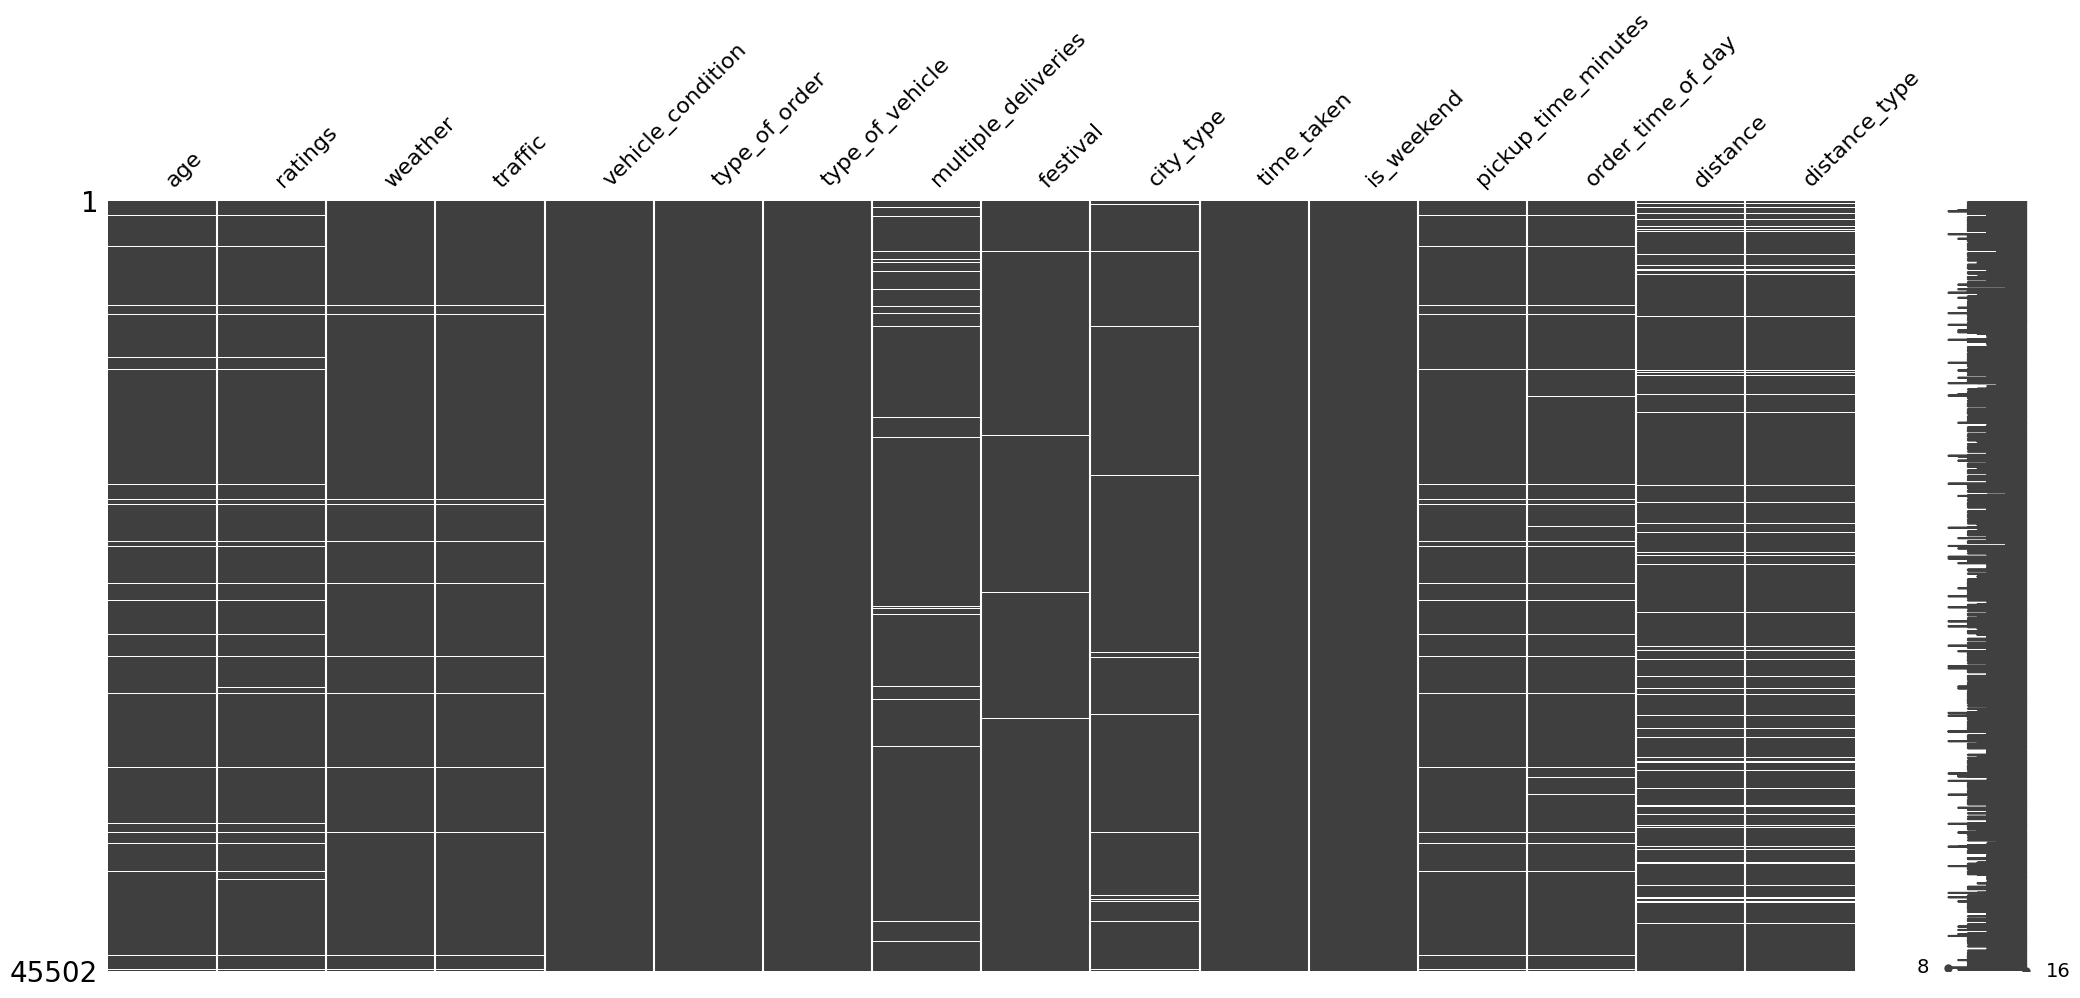

In [15]:
import missingno as msno

msno.matrix(df)

In [16]:
# columns that have missing values

missing_cols = (
                    df
                    .isna()
                    .any(axis=0)
                    .loc[lambda x: x]
                    .index
                )

missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'pickup_time_minutes', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

# Drop Missing values

In [17]:
temp_df = df.copy().dropna()

In [18]:
# split into X and y

X = temp_df.drop(columns='time_taken')
y = temp_df['time_taken']

X

age  ratings     weather traffic  vehicle_condition type_of_order  \
0      37.0      4.9       sunny    high                  2         snack   
1      34.0      4.5      stormy     jam                  2         snack   
2      23.0      4.4  sandstorms     low                  0        drinks   
3      38.0      4.7       sunny  medium                  0        buffet   
4      32.0      4.6      cloudy    high                  1         snack   
...     ...      ...         ...     ...                ...           ...   
45496  35.0      4.2       windy     jam                  2        drinks   
45497  30.0      4.8       windy    high                  1          meal   
45499  30.0      4.9      cloudy     low                  1        drinks   
45500  20.0      4.7      cloudy    high                  0         snack   
45501  23.0      4.9         fog  medium                  2         snack   

      type_of_vehicle  multiple_deliveries festival      city_type  \
0          motorcycle                  0.0       no          urban   
1             scooter                  1.0       no  metropolitian   
2          motorcycle                  1.0       no          urban   
3          motorcycle                  1.0       no  metropolitian   
4             scooter                  1.0       no  metropolitian   
...               ...                  ...      ...            ...   
45496      motorcycle                  1.0       no  metropolitian   
45497      motorcycle                  0.0       no  metropolitian   
45499         scooter                  0.0       no  metropolitian   
45500      motorcycle                  1.0       no  metropolitian   
45501         scooter                  1.0       no  metropolitian   

       is_weekend  pickup_time_minutes order_time_of_day   distance  \
0               1                 15.0           morning   3.025149   
1               0                  5.0           evening  20.183530   
2               1                 15.0           morning   1.552758   
3               0                 10.0           evening   7.790401   
4               1                 15.0         afternoon   6.210138   
...           ...                  ...               ...        ...   
45496           0                 10.0             night  16.600272   
45497           0                 10.0           morning   1.489846   
45499           0                 15.0             night   4.657195   
45500           0                  5.0         afternoon   6.232393   
45501           0                  5.0         afternoon  12.074396   

      distance_type  
0             short  
1         very_long  
2             short  
3            medium  
4            medium  
...             ...  
45496     very_long  
45497         short  
45499         short  
45500        medium  
45501          long  

[37695 rows x 15 columns]

In [19]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [20]:
print("The size of train data is",X_train.shape)
print("The shape of test data is",X_test.shape)

The size of train data is (30156, 15)
The shape of test data is (7539, 15)


In [21]:
# missing values in train data

X_train.isna().sum()

age                    0
ratings                0
weather                0
traffic                0
vehicle_condition      0
type_of_order          0
type_of_vehicle        0
multiple_deliveries    0
festival               0
city_type              0
is_weekend             0
pickup_time_minutes    0
order_time_of_day      0
distance               0
distance_type          0
dtype: int64

In [22]:
# transform target column

pt = PowerTransformer()

y_train_pt = pt.fit_transform(y_train.values.reshape(-1,1))
y_test_pt = pt.transform(y_test.values.reshape(-1,1))

In [23]:
missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'pickup_time_minutes', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

In [24]:
# percentage of rows in data having missing values

(
    X_train
    .isna()
    .any(axis=1)
    .mean()
    .round(2) * 100
)


np.float64(0.0)

# Pre-Processing Pipeline

In [25]:
num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = ['weather',
                    'type_of_order',
                    'type_of_vehicle',
                    "festival",
                    "city_type",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

In [26]:
nominal_cat_cols

['weather',
 'type_of_order',
 'type_of_vehicle',
 'festival',
 'city_type',
 'is_weekend',
 'order_time_of_day']

In [27]:
X_train.isna().sum()

age                    0
ratings                0
weather                0
traffic                0
vehicle_condition      0
type_of_order          0
type_of_vehicle        0
multiple_deliveries    0
festival               0
city_type              0
is_weekend             0
pickup_time_minutes    0
order_time_of_day      0
distance               0
distance_type          0
dtype: int64

In [28]:
# # features to fill values with mode

# features_to_fill_mode = ['multiple_deliveries','festival','city_type']
# features_to_fill_missing = [col for col in nominal_cat_cols if col not in features_to_fill_mode]

# features_to_fill_missing

In [29]:
# # simple imputer to fill categorical vars with mode

# simple_imputer = ColumnTransformer(transformers=[
#     ("mode_imputer",SimpleImputer(strategy="most_frequent",add_indicator=True),features_to_fill_mode),
#     ("missing_imputer",SimpleImputer(strategy="constant",fill_value="missing",add_indicator=True),features_to_fill_missing)
# ],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)

# simple_imputer

In [30]:
# simple_imputer.fit_transform(X_train)

In [31]:
# simple_imputer.fit_transform(X_train).isna().sum()

In [32]:
# knn imputer

# knn_imputer = KNNImputer(n_neighbors=5)

In [33]:
# do basic preprocessing

num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = ['weather','type_of_order',
                    'type_of_vehicle',"festival",
                    "city_type",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

In [34]:
# generate order for ordinal encoding

traffic_order = ["low","medium","high","jam"]

distance_type_order = ["short","medium","long","very_long"]

In [35]:
# unique categories the ordinal columns

for col in ordinal_cat_cols:
    print(col,X_train[col].unique())

traffic ['jam' 'medium' 'high' 'low']
distance_type ['medium' 'short' 'long' 'very_long']


In [36]:
# build a preprocessor

preprocessor = ColumnTransformer(transformers=[
    ("scale", MinMaxScaler(), num_cols),
    ("nominal_encode", OneHotEncoder(drop="first",handle_unknown="ignore",
                                     sparse_output=False), nominal_cat_cols),
    ("ordinal_encode", OrdinalEncoder(categories=[traffic_order,distance_type_order],
                                      encoded_missing_value=-999,
                                      handle_unknown="use_encoded_value",
                                      unknown_value=-1), ordinal_cat_cols)
],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)


preprocessor

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('scale', MinMaxScaler(),
                                 ['age', 'ratings', 'pickup_time_minutes',
                                  'distance']),
                                ('nominal_encode',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['weather', 'type_of_order', 'type_of_vehicle',
                                  'festival', 'city_type', 'is_weekend',
                                  'order_time_of_day']),
                                ('ordinal_encode',
                                 OrdinalEncoder(categories=[['low', 'medium',
                                                             'high', 'jam'],
                                                            ['short', 'medium',
                                                             'long',
                                                             'very_long']],
                                                encoded_missing_value=-999,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['traffic', 'distance_type'])],
                  verbose_feature_names_out=False)

In [37]:
# build the pipeline

processing_pipeline = Pipeline(steps=[
                                # ("simple_imputer",simple_imputer),
                                ("preprocess",preprocessor)
                                # ("knn_imputer",knn_imputer)
                            ])

processing_pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('scale', MinMaxScaler(),
                                                  ['age', 'ratings',
                                                   'pickup_time_minutes',
                                                   'distance']),
                                                 ('nominal_encode',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['weather', 'type_of_order',
                                                   'type_of_vehicle',
                                                   'festival', 'city_type',
                                                   'is_weekend',
                                                   'order_time_of_day']),
                                                 ('ordinal_encode',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'medium',
                                                                              'high',
                                                                              'jam'],
                                                                             ['short',
                                                                              'medium',
                                                                              'long',
                                                                              'very_long']],
                                                                 encoded_missing_value=-999,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['traffic',
                                                   'distance_type'])],
                                   verbose_feature_names_out=False))])

In [38]:
# do data preprocessing

X_train_trans = processing_pipeline.fit_transform(X_train)

X_test_trans = processing_pipeline.transform(X_test)

In [39]:
X_train_trans

age  ratings  pickup_time_minutes  distance  weather_fog  \
8708   0.473684     0.56                  1.0  0.404165          0.0   
25198  1.000000     0.76                  0.0  0.154044          0.0   
34049  0.473684     0.80                  0.5  0.002461          0.0   
25987  1.000000     0.92                  1.0  0.460411          0.0   
37121  0.526316     0.76                  0.5  0.243676          0.0   
...         ...      ...                  ...       ...          ...   
20239  0.578947     0.92                  0.5  0.451895          0.0   
7590   0.052632     1.00                  1.0  0.612270          0.0   
13610  0.526316     0.92                  0.0  0.322877          0.0   
1045   0.947368     0.96                  0.5  0.004486          0.0   
18968  0.684211     0.96                  0.0  0.481978          0.0   

       weather_sandstorms  weather_stormy  weather_sunny  weather_windy  \
8708                  0.0             0.0            1.0            0.0   
25198                 1.0             0.0            0.0            0.0   
34049                 0.0             0.0            1.0            0.0   
25987                 1.0             0.0            0.0            0.0   
37121                 0.0             0.0            0.0            1.0   
...                   ...             ...            ...            ...   
20239                 0.0             0.0            1.0            0.0   
7590                  1.0             0.0            0.0            0.0   
13610                 0.0             0.0            0.0            0.0   
1045                  0.0             0.0            1.0            0.0   
18968                 0.0             0.0            0.0            1.0   

       type_of_order_drinks  ...  city_type_semi-urban  city_type_urban  \
8708                    1.0  ...                   1.0              0.0   
25198                   0.0  ...                   0.0              0.0   
34049                   0.0  ...                   0.0              1.0   
25987                   0.0  ...                   0.0              0.0   
37121                   0.0  ...                   0.0              0.0   
...                     ...  ...                   ...              ...   
20239                   0.0  ...                   0.0              0.0   
7590                    0.0  ...                   0.0              0.0   
13610                   0.0  ...                   0.0              0.0   
1045                    0.0  ...                   0.0              1.0   
18968                   0.0  ...                   0.0              1.0   

       is_weekend_1  order_time_of_day_evening  order_time_of_day_morning  \
8708            0.0                        0.0                        0.0   
25198           1.0                        0.0                        0.0   
34049           0.0                        0.0                        1.0   
25987           1.0                        0.0                        0.0   
37121           1.0                        0.0                        0.0   
...             ...                        ...                        ...   
20239           1.0                        1.0                        0.0   
7590            1.0                        1.0                        0.0   
13610           1.0                        0.0                        0.0   
1045            1.0                        0.0                        1.0   
18968           0.0                        0.0                        0.0   

       order_time_of_day_night  traffic  distance_type  vehicle_condition  \
8708                       1.0      3.0            1.0                  0   
25198                      0.0      1.0            0.0                  0   
34049                      0.0      2.0            0.0                  1   
25987                      1.0      0.0            2.0                  0   
37121                      0.0     

In [40]:
%pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [41]:
from lightgbm import LGBMRegressor
import optuna

/opt/homebrew/Cellar/jupyterlab/4.3.1/libexec/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.compose import TransformedTargetRegressor

In [43]:
def objective(trial):
    with mlflow.start_run(nested=True):
        params = {
            "n_estimators": trial.suggest_int("n_estimators",10,200),
            "max_depth": trial.suggest_int("max_depth",1,40),
            "learning_rate": trial.suggest_float("learning_rate",0.1,0.8),
            "subsample": trial.suggest_float("subsample",0.5,1),
            "min_child_weight": trial.suggest_int("min_child_weight",5,20),
            "min_split_gain": trial.suggest_float("min_split_gain",0,10),
            "reg_lambda": trial.suggest_float("reg_lambda",0,100),
            "random_state": 42,
            "n_jobs": -1,
        }

        # log model parameters
        mlflow.log_params(params)

        xgb_reg = LGBMRegressor(**params)
        model = TransformedTargetRegressor(regressor=xgb_reg,transformer=pt)

        # train the model
        model.fit(X_train_trans,y_train)

        # get the predictions
        y_pred_train = model.predict(X_train_trans)
        y_pred_test = model.predict(X_test_trans)


        # perform cross validation
        cv_score = cross_val_score(model,
                                X_train_trans,
                                y_train,
                                cv=5,
                                scoring="neg_mean_absolute_error",
                                n_jobs=-1)

        # mean score
        mean_score = -(cv_score.mean())
        # log avg cross val error
        mlflow.log_metric("cross_val_error",mean_score)

        return mean_score

In [ ]:
# create optuna study
study = optuna.create_study(direction="minimize")

with mlflow.start_run(run_name="best_model"):
    # optimize the objective function
    study.optimize(objective,n_trials=50,n_jobs=-1,show_progress_bar=True)

    # log the best parameters
    mlflow.log_params(study.best_params)

    # log the best score
    mlflow.log_metric("best_score",study.best_value)

    # train the model on best parameters
    best_lgbm = LGBMRegressor(**study.best_params)

    best_lgbm.fit(X_train_trans,y_train_pt.values.ravel())

    # get the predictions
    y_pred_train = best_lgbm.predict(X_train_trans)
    y_pred_test = best_lgbm.predict(X_test_trans)

    # get the actual predictions values
    y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
    y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))


    # perform cross validation
    model = TransformedTargetRegressor(regressor=best_lgbm,
                                        transformer=pt)


    scores = cross_val_score(model,
                         X_train_trans,
                         y_train,
                         scoring="neg_mean_absolute_error",
                         cv=5,n_jobs=-1)

    # log metrics
    mlflow.log_metric("training_error",mean_absolute_error(y_train,y_pred_train_org))
    mlflow.log_metric("test_error",mean_absolute_error(y_test,y_pred_test_org))
    mlflow.log_metric("training_r2",r2_score(y_train,y_pred_train_org))
    mlflow.log_metric("test_r2",r2_score(y_test,y_pred_test_org))
    mlflow.log_metric("cross_val",- scores.mean())

    # log the best model
    mlflow.sklearn.log_model(best_lgbm,artifact_path="model")

[I 2025-04-06 20:21:15,880] A new study created in memory with name: no-name-054f36b2-a364-45b9-b704-8c588204d3fd
  0%|                                                                                                                                                                                | 0/50 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wi

Best trial: 7. Best value: 3.74355:   2%|██▋                                                                                                                                 | 1/50 [00:22<18:46, 22.99s/it]

[I 2025-04-06 20:21:39,417] Trial 7 finished with value: 3.743545762070427 and parameters: {'n_estimators': 126, 'max_depth': 34, 'learning_rate': 0.16110722402376057, 'subsample': 0.9988602723401159, 'min_child_weight': 17, 'min_split_gain': 7.753966022880475, 'reg_lambda': 87.20904336876534}. Best is trial 7 with value: 3.743545762070427.


Best trial: 7. Best value: 3.74355:   4%|█████▎                                                                                                                              | 2/50 [00:24<08:05, 10.12s/it]

[I 2025-04-06 20:21:40,530] Trial 2 finished with value: 3.7698154576093237 and parameters: {'n_estimators': 61, 'max_depth': 31, 'learning_rate': 0.1306629114402014, 'subsample': 0.5788994230342851, 'min_child_weight': 10, 'min_split_gain': 9.174128779644787, 'reg_lambda': 78.46780510239256}. Best is trial 7 with value: 3.743545762070427.


Best trial: 7. Best value: 3.74355:   6%|███████▉                                                                                                                            | 3/50 [00:25<04:37,  5.91s/it]

[I 2025-04-06 20:21:41,436] Trial 6 finished with value: 3.852440664716937 and parameters: {'n_estimators': 164, 'max_depth': 38, 'learning_rate': 0.7368973048286935, 'subsample': 0.9537749031973806, 'min_child_weight': 19, 'min_split_gain': 9.028372801315722, 'reg_lambda': 17.73365607800278}. Best is trial 7 with value: 3.743545762070427.


Best trial: 0. Best value: 3.6834:   8%|██████████▋                                                                                                                          | 4/50 [00:25<03:02,  3.97s/it]

[I 2025-04-06 20:21:42,427] Trial 0 finished with value: 3.6833990050847425 and parameters: {'n_estimators': 72, 'max_depth': 29, 'learning_rate': 0.27724726695961077, 'subsample': 0.881506312545399, 'min_child_weight': 6, 'min_split_gain': 6.114155341717092, 'reg_lambda': 87.50014975015985}. Best is trial 0 with value: 3.6833990050847425.


Best trial: 5. Best value: 3.64379:  10%|█████████████▏                                                                                                                      | 5/50 [00:26<02:10,  2.89s/it]

[I 2025-04-06 20:21:43,412] Trial 5 finished with value: 3.6437876809820358 and parameters: {'n_estimators': 52, 'max_depth': 22, 'learning_rate': 0.7617747497765571, 'subsample': 0.8656443350271705, 'min_child_weight': 8, 'min_split_gain': 2.9567789914588305, 'reg_lambda': 94.22689198350473}. Best is trial 5 with value: 3.6437876809820358.


Best trial: 5. Best value: 3.64379:  12%|███████████████▊                                                                                                                    | 6/50 [00:27<01:39,  2.25s/it]

[I 2025-04-06 20:21:44,423] Trial 3 finished with value: 3.6932800573866635 and parameters: {'n_estimators': 72, 'max_depth': 40, 'learning_rate': 0.55829922670984, 'subsample': 0.850145271102656, 'min_child_weight': 15, 'min_split_gain': 4.257189851893233, 'reg_lambda': 51.39800484097397}. Best is trial 5 with value: 3.6437876809820358.


Best trial: 5. Best value: 3.64379:  14%|██████████████████▍                                                                                                                 | 7/50 [00:28<01:19,  1.84s/it]

[I 2025-04-06 20:21:45,417] Trial 4 finished with value: 3.7219282285407735 and parameters: {'n_estimators': 85, 'max_depth': 27, 'learning_rate': 0.6404697988750938, 'subsample': 0.8853958555824261, 'min_child_weight': 20, 'min_split_gain': 8.835508985764957, 'reg_lambda': 57.29108383335794}. Best is trial 5 with value: 3.6437876809820358.


Best trial: 5. Best value: 3.64379:  16%|█████████████████████                                                                                                               | 8/50 [00:30<01:06,  1.59s/it]

[I 2025-04-06 20:21:46,467] Trial 1 finished with value: 3.769457125344627 and parameters: {'n_estimators': 80, 'max_depth': 36, 'learning_rate': 0.14703056807400627, 'subsample': 0.904328621714247, 'min_child_weight': 9, 'min_split_gain': 7.923207615875616, 'reg_lambda': 55.967946068720344}. Best is trial 5 with value: 3.6437876809820358.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

Best trial: 8. Best value: 3.63893:  18%|███████████████████████▊                                                                                                            | 9/50 [01:02<07:47, 11.40s/it]

[I 2025-04-06 20:22:19,426] Trial 8 finished with value: 3.638929481605895 and parameters: {'n_estimators': 28, 'max_depth': 9, 'learning_rate': 0.207159330503894, 'subsample': 0.8396031257409655, 'min_child_weight': 6, 'min_split_gain': 4.2353042712895554, 'reg_lambda': 89.46117697408414}. Best is trial 8 with value: 3.638929481605895.


Best trial: 8. Best value: 3.63893:  20%|██████████████████████████▏                                                                                                        | 10/50 [01:03<05:27,  8.18s/it]

[I 2025-04-06 20:22:20,408] Trial 9 finished with value: 3.727560402713151 and parameters: {'n_estimators': 197, 'max_depth': 30, 'learning_rate': 0.4198240314018378, 'subsample': 0.6132896703159525, 'min_child_weight': 12, 'min_split_gain': 7.345487146769352, 'reg_lambda': 67.09104747080596}. Best is trial 8 with value: 3.638929481605895.


Best trial: 8. Best value: 3.63893:  22%|████████████████████████████▊                                                                                                      | 11/50 [01:04<03:53,  5.99s/it]

[I 2025-04-06 20:22:21,418] Trial 10 finished with value: 3.7562787180609383 and parameters: {'n_estimators': 46, 'max_depth': 32, 'learning_rate': 0.4455257946806978, 'subsample': 0.6730301339950937, 'min_child_weight': 8, 'min_split_gain': 8.495073235476077, 'reg_lambda': 64.05319281663722}. Best is trial 8 with value: 3.638929481605895.


Best trial: 11. Best value: 3.48472:  24%|███████████████████████████████▏                                                                                                  | 12/50 [01:05<02:49,  4.46s/it]

[I 2025-04-06 20:22:22,390] Trial 11 finished with value: 3.484723180572721 and parameters: {'n_estimators': 70, 'max_depth': 20, 'learning_rate': 0.6417918194171712, 'subsample': 0.8260203243240807, 'min_child_weight': 16, 'min_split_gain': 1.5059704273163943, 'reg_lambda': 71.80463285793365}. Best is trial 11 with value: 3.484723180572721.


Best trial: 11. Best value: 3.48472:  26%|█████████████████████████████████▊                                                                                                | 13/50 [01:06<02:06,  3.42s/it]

[I 2025-04-06 20:22:23,422] Trial 12 finished with value: 3.7174320918463017 and parameters: {'n_estimators': 35, 'max_depth': 19, 'learning_rate': 0.2539875495229471, 'subsample': 0.8151155542341963, 'min_child_weight': 14, 'min_split_gain': 9.141609256567252, 'reg_lambda': 13.61823969864966}. Best is trial 11 with value: 3.484723180572721.


Best trial: 11. Best value: 3.48472:  28%|████████████████████████████████████▍                                                                                             | 14/50 [01:07<01:36,  2.69s/it]

[I 2025-04-06 20:22:24,428] Trial 13 finished with value: 3.6362523549090495 and parameters: {'n_estimators': 150, 'max_depth': 13, 'learning_rate': 0.15207413110181883, 'subsample': 0.7154043614416716, 'min_child_weight': 17, 'min_split_gain': 4.588678151627881, 'reg_lambda': 55.231216159246024}. Best is trial 11 with value: 3.484723180572721.


Best trial: 11. Best value: 3.48472:  30%|███████████████████████████████████████                                                                                           | 15/50 [01:08<01:16,  2.17s/it]

[I 2025-04-06 20:22:25,400] Trial 14 finished with value: 3.6468891205661556 and parameters: {'n_estimators': 20, 'max_depth': 8, 'learning_rate': 0.4169916616963228, 'subsample': 0.826131221689134, 'min_child_weight': 8, 'min_split_gain': 5.144886529010209, 'reg_lambda': 15.152510748256077}. Best is trial 11 with value: 3.484723180572721.


Best trial: 11. Best value: 3.48472:  32%|█████████████████████████████████████████▌                                                                                        | 16/50 [01:09<01:01,  1.82s/it]

[I 2025-04-06 20:22:26,406] Trial 15 finished with value: 3.60596020872356 and parameters: {'n_estimators': 39, 'max_depth': 38, 'learning_rate': 0.21915266987470197, 'subsample': 0.9438476014066107, 'min_child_weight': 15, 'min_split_gain': 3.5979909498386062, 'reg_lambda': 66.19666957294862}. Best is trial 11 with value: 3.484723180572721.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stop

Best trial: 16. Best value: 3.36099:  34%|████████████████████████████████████████████▏                                                                                     | 17/50 [01:43<06:09, 11.21s/it]

[I 2025-04-06 20:22:59,451] Trial 16 finished with value: 3.3609864696861136 and parameters: {'n_estimators': 113, 'max_depth': 21, 'learning_rate': 0.5830094546763167, 'subsample': 0.7625018091582875, 'min_child_weight': 12, 'min_split_gain': 0.28570054799007427, 'reg_lambda': 34.424958244397686}. Best is trial 16 with value: 3.3609864696861136.


Best trial: 16. Best value: 3.36099:  36%|██████████████████████████████████████████████▊                                                                                   | 18/50 [01:43<04:20,  8.13s/it]

[I 2025-04-06 20:23:00,407] Trial 17 finished with value: 3.779821246826016 and parameters: {'n_estimators': 102, 'max_depth': 2, 'learning_rate': 0.5617769009405602, 'subsample': 0.7376872256553996, 'min_child_weight': 12, 'min_split_gain': 0.8095186389044053, 'reg_lambda': 74.8510140780527}. Best is trial 16 with value: 3.3609864696861136.


Best trial: 16. Best value: 3.36099:  38%|█████████████████████████████████████████████████▍                                                                                | 19/50 [01:44<03:05,  5.99s/it]

[I 2025-04-06 20:23:01,411] Trial 18 finished with value: 3.5615058281957714 and parameters: {'n_estimators': 109, 'max_depth': 3, 'learning_rate': 0.5578333459001176, 'subsample': 0.7633830108555579, 'min_child_weight': 13, 'min_split_gain': 0.21952659896776927, 'reg_lambda': 31.060559948883064}. Best is trial 16 with value: 3.3609864696861136.


Best trial: 19. Best value: 3.22112:  40%|████████████████████████████████████████████████████                                                                              | 20/50 [01:46<02:15,  4.50s/it]

[I 2025-04-06 20:23:02,450] Trial 19 finished with value: 3.2211221543684956 and parameters: {'n_estimators': 106, 'max_depth': 18, 'learning_rate': 0.5593643679233176, 'subsample': 0.7674122279586678, 'min_child_weight': 12, 'min_split_gain': 0.027836120901914452, 'reg_lambda': 36.92665908652525}. Best is trial 19 with value: 3.2211221543684956.


Best trial: 19. Best value: 3.22112:  42%|██████████████████████████████████████████████████████▌                                                                           | 21/50 [01:47<01:40,  3.46s/it]

[I 2025-04-06 20:23:03,476] Trial 20 finished with value: 3.3013828896752884 and parameters: {'n_estimators': 102, 'max_depth': 18, 'learning_rate': 0.5667703742691199, 'subsample': 0.758696545222707, 'min_child_weight': 12, 'min_split_gain': 0.2189882624161803, 'reg_lambda': 37.58098360635641}. Best is trial 19 with value: 3.2211221543684956.


Best trial: 19. Best value: 3.22112:  44%|█████████████████████████████████████████████████████████▏                                                                        | 22/50 [01:47<01:15,  2.70s/it]

[I 2025-04-06 20:23:04,405] Trial 21 finished with value: 3.3455826104642177 and parameters: {'n_estimators': 104, 'max_depth': 18, 'learning_rate': 0.5721927944737921, 'subsample': 0.7534803983113914, 'min_child_weight': 12, 'min_split_gain': 0.41828842823260626, 'reg_lambda': 36.74258782431441}. Best is trial 19 with value: 3.2211221543684956.


Best trial: 19. Best value: 3.22112:  46%|███████████████████████████████████████████████████████████▊                                                                      | 23/50 [01:48<00:59,  2.19s/it]

[I 2025-04-06 20:23:05,405] Trial 22 finished with value: 4.270150825035542 and parameters: {'n_estimators': 107, 'max_depth': 1, 'learning_rate': 0.5603504494763126, 'subsample': 0.7692561163651438, 'min_child_weight': 12, 'min_split_gain': 0.3420168515244435, 'reg_lambda': 37.866819363110906}. Best is trial 19 with value: 3.2211221543684956.


Best trial: 19. Best value: 3.22112:  48%|██████████████████████████████████████████████████████████████▍                                                                   | 24/50 [01:49<00:47,  1.83s/it]

[I 2025-04-06 20:23:06,384] Trial 23 finished with value: 4.271287269435616 and parameters: {'n_estimators': 99, 'max_depth': 1, 'learning_rate': 0.5823288098259577, 'subsample': 0.772701151751477, 'min_child_weight': 13, 'min_split_gain': 0.35344957189752035, 'reg_lambda': 36.185167752682666}. Best is trial 19 with value: 3.2211221543684956.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

Best trial: 19. Best value: 3.22112:  50%|█████████████████████████████████████████████████████████████████                                                                 | 25/50 [02:22<04:39, 11.18s/it]

[I 2025-04-06 20:23:39,391] Trial 24 finished with value: 3.484398889290243 and parameters: {'n_estimators': 135, 'max_depth': 16, 'learning_rate': 0.34402621222338636, 'subsample': 0.6600357402987819, 'min_child_weight': 10, 'min_split_gain': 1.8085056301193072, 'reg_lambda': 25.815230148089192}. Best is trial 19 with value: 3.2211221543684956.


Best trial: 19. Best value: 3.22112:  52%|███████████████████████████████████████████████████████████████████▌                                                              | 26/50 [02:23<03:15,  8.13s/it]

[I 2025-04-06 20:23:40,411] Trial 25 finished with value: 3.511069785730876 and parameters: {'n_estimators': 137, 'max_depth': 15, 'learning_rate': 0.3480084928194336, 'subsample': 0.6889161829823932, 'min_child_weight': 10, 'min_split_gain': 1.9263113415039923, 'reg_lambda': 43.83330783145061}. Best is trial 19 with value: 3.2211221543684956.


Best trial: 19. Best value: 3.22112:  54%|██████████████████████████████████████████████████████████████████████▏                                                           | 27/50 [02:24<02:17,  5.99s/it]

[I 2025-04-06 20:23:41,396] Trial 26 finished with value: 3.481789036895409 and parameters: {'n_estimators': 134, 'max_depth': 16, 'learning_rate': 0.3565493342203867, 'subsample': 0.6640990034995573, 'min_child_weight': 10, 'min_split_gain': 2.130763581505077, 'reg_lambda': 0.5525533921103332}. Best is trial 19 with value: 3.2211221543684956.


Best trial: 19. Best value: 3.22112:  56%|████████████████████████████████████████████████████████████████████████▊                                                         | 28/50 [02:25<01:38,  4.49s/it]

[I 2025-04-06 20:23:42,389] Trial 27 finished with value: 3.5103790407507818 and parameters: {'n_estimators': 129, 'max_depth': 14, 'learning_rate': 0.3595821118603777, 'subsample': 0.6820565049057864, 'min_child_weight': 10, 'min_split_gain': 2.124168372857462, 'reg_lambda': 25.988917529485132}. Best is trial 19 with value: 3.2211221543684956.


Best trial: 19. Best value: 3.22112:  58%|███████████████████████████████████████████████████████████████████████████▍                                                      | 29/50 [02:27<01:14,  3.56s/it]

[I 2025-04-06 20:23:43,781] Trial 28 finished with value: 3.536688138840507 and parameters: {'n_estimators': 128, 'max_depth': 16, 'learning_rate': 0.4907130200792801, 'subsample': 0.6543870293531535, 'min_child_weight': 11, 'min_split_gain': 1.9617630984179821, 'reg_lambda': 44.128767222989644}. Best is trial 19 with value: 3.2211221543684956.


Best trial: 19. Best value: 3.22112:  60%|██████████████████████████████████████████████████████████████████████████████                                                    | 30/50 [02:27<00:53,  2.68s/it]

[I 2025-04-06 20:23:44,401] Trial 29 finished with value: 3.5116278965263263 and parameters: {'n_estimators': 137, 'max_depth': 17, 'learning_rate': 0.34656523280026647, 'subsample': 0.6865209860677667, 'min_child_weight': 11, 'min_split_gain': 1.7898648328561517, 'reg_lambda': 24.266353125727935}. Best is trial 19 with value: 3.2211221543684956.


Best trial: 19. Best value: 3.22112:  62%|████████████████████████████████████████████████████████████████████████████████▌                                                 | 31/50 [02:28<00:41,  2.18s/it]

[I 2025-04-06 20:23:45,409] Trial 30 finished with value: 3.5534180537346716 and parameters: {'n_estimators': 135, 'max_depth': 13, 'learning_rate': 0.49229713093715677, 'subsample': 0.6716646800539885, 'min_child_weight': 10, 'min_split_gain': 2.00798780900547, 'reg_lambda': 1.4861655348764202}. Best is trial 19 with value: 3.2211221543684956.


Best trial: 19. Best value: 3.22112:  64%|███████████████████████████████████████████████████████████████████████████████████▏                                              | 32/50 [02:30<00:33,  1.83s/it]

[I 2025-04-06 20:23:46,445] Trial 31 finished with value: 3.51166997989412 and parameters: {'n_estimators': 134, 'max_depth': 16, 'learning_rate': 0.3464100961504437, 'subsample': 0.6732898157299767, 'min_child_weight': 10, 'min_split_gain': 2.009341597129211, 'reg_lambda': 25.10517949336301}. Best is trial 19 with value: 3.2211221543684956.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 19. Best value: 3.22112:  66%|█████████████████████████████████████████████████████████████████████████████████████▊                                            | 33/50 [03:02<03:09, 11.17s/it]

[I 2025-04-06 20:24:19,396] Trial 32 finished with value: 3.472363248517999 and parameters: {'n_estimators': 91, 'max_depth': 24, 'learning_rate': 0.6745914068403748, 'subsample': 0.7315985513036019, 'min_child_weight': 14, 'min_split_gain': 0.8203822861028568, 'reg_lambda': 43.34464642694342}. Best is trial 19 with value: 3.2211221543684956.


Best trial: 19. Best value: 3.22112:  68%|████████████████████████████████████████████████████████████████████████████████████████▍                                         | 34/50 [03:03<02:09,  8.12s/it]

[I 2025-04-06 20:24:20,400] Trial 33 finished with value: 3.440898175320605 and parameters: {'n_estimators': 89, 'max_depth': 23, 'learning_rate': 0.6704562602437015, 'subsample': 0.7977331438268167, 'min_child_weight': 14, 'min_split_gain': 1.0918841168952107, 'reg_lambda': 42.9114662297304}. Best is trial 19 with value: 3.2211221543684956.


Best trial: 19. Best value: 3.22112:  70%|███████████████████████████████████████████████████████████████████████████████████████████                                       | 35/50 [03:04<01:29,  5.99s/it]

[I 2025-04-06 20:24:21,424] Trial 34 finished with value: 3.549060402821054 and parameters: {'n_estimators': 91, 'max_depth': 26, 'learning_rate': 0.6796972128380507, 'subsample': 0.7900583913471703, 'min_child_weight': 14, 'min_split_gain': 1.0822765160121866, 'reg_lambda': 43.24614443140429}. Best is trial 19 with value: 3.2211221543684956.


Best trial: 19. Best value: 3.22112:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 36/50 [03:05<01:02,  4.48s/it]

[I 2025-04-06 20:24:22,392] Trial 35 finished with value: 3.5281345104303155 and parameters: {'n_estimators': 91, 'max_depth': 24, 'learning_rate': 0.6764590220795874, 'subsample': 0.7973690180238667, 'min_child_weight': 14, 'min_split_gain': 1.0557044486842289, 'reg_lambda': 44.42892706595241}. Best is trial 19 with value: 3.2211221543684956.


Best trial: 19. Best value: 3.22112:  74%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 37/50 [03:07<00:44,  3.46s/it]

[I 2025-04-06 20:24:23,449] Trial 36 finished with value: 3.4920900074330996 and parameters: {'n_estimators': 91, 'max_depth': 25, 'learning_rate': 0.6651137307178099, 'subsample': 0.8011085493703959, 'min_child_weight': 14, 'min_split_gain': 1.124798554951839, 'reg_lambda': 42.994923652072984}. Best is trial 19 with value: 3.2211221543684956.


Best trial: 19. Best value: 3.22112:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 38/50 [03:08<00:32,  2.73s/it]

[I 2025-04-06 20:24:24,472] Trial 37 finished with value: 3.5456426144634094 and parameters: {'n_estimators': 88, 'max_depth': 23, 'learning_rate': 0.6757493493290117, 'subsample': 0.7988930569136931, 'min_child_weight': 14, 'min_split_gain': 1.226944566004321, 'reg_lambda': 44.260001371434306}. Best is trial 19 with value: 3.2211221543684956.


Best trial: 19. Best value: 3.22112:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 39/50 [03:08<00:24,  2.19s/it]

[I 2025-04-06 20:24:25,407] Trial 38 finished with value: 3.565091751360428 and parameters: {'n_estimators': 91, 'max_depth': 25, 'learning_rate': 0.6633487385085604, 'subsample': 0.7945993263187408, 'min_child_weight': 14, 'min_split_gain': 1.0774311711219307, 'reg_lambda': 45.06472654416396}. Best is trial 19 with value: 3.2211221543684956.


Best trial: 19. Best value: 3.22112:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 40/50 [03:11<00:21,  2.17s/it]

[I 2025-04-06 20:24:27,529] Trial 39 finished with value: 3.525316682877606 and parameters: {'n_estimators': 91, 'max_depth': 24, 'learning_rate': 0.6780124320808161, 'subsample': 0.7926735465643203, 'min_child_weight': 14, 'min_split_gain': 1.0181656008245787, 'reg_lambda': 45.18908648536039}. Best is trial 19 with value: 3.2211221543684956.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [ ]:
study.best_params

In [ ]:
study.best_value

In [ ]:
# optimization history plot

optuna.visualization.plot_optimization_history(study)

In [ ]:
# plot hyperparameter importance plot

optuna.visualization.plot_param_importances(study)

In [ ]:
# slice plot

optuna.visualization.plot_slice(study)